<a href="https://colab.research.google.com/github/multiplexcuriosus/sam_pipeline/blob/main/SAM_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Before you start

Let's make sure that we have acce1ss to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Wed Apr 24 19:55:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Install Segment Anything Model (SAM) and other dependencies

In [2]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

  Preparing metadata (setup.py) ... done


In [3]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

In [4]:
# If necessary, download weights
#!mkdir -p {HOME}/weights
#!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [5]:
# Do imports
import os
from os import path
import sys
sys.path.append('/content/drive/MyDrive/ETH/FS24/RSL_SP/dev/scripts')
import cv2
from google.colab import drive
from google.colab.patches import cv2_imshow
import torch
import supervision as sv
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import time
import numpy as np
import json

# Mount google drive (if necessary)
#drive.mount("/content/drive/")
drive.mount("/content/drive/", force_remount=True)

import cornerDetection,hline,sline




Mounted at /content/drive/


## Create environment variables and manage input data

In [11]:
# Create environment variables
HOME = '/content/drive/MyDrive/ETH/FS24/RSL_SP/dev/SAM/'


# Data management

PRIMARY_SEL_NAME = 'sel1'
SEL_SUBTYPE = '_small'
SEL_NAME = PRIMARY_SEL_NAME + SEL_SUBTYPE

MODEL_NAME = 'vit_h'

IMAGES_FOLDER = '/content/drive/MyDrive/ETH/FS24/RSL_SP/dev/images/'
OUTPUT_FOLDER = '/content/drive/MyDrive/ETH/FS24/RSL_SP/dev/output/pipeline_tests/' + MODEL_NAME  + "/"+SEL_NAME + "/"
if not path.exists(OUTPUT_FOLDER):
  os.mkdir(OUTPUT_FOLDER)


## Load Model

In [7]:
# Load model
MODEL_TYPE = "vit_h"
if MODEL_TYPE == "vit_l":
  CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_l_0b3195.pth")
elif MODEL_TYPE == "vit_h":
  CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
elif MODEL_TYPE == "vit_b":
  CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_b_01ec64.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

/content/drive/MyDrive/ETH/FS24/RSL_SP/dev/SAM/weights/sam_vit_h_4b8939.pth ; exist: True


## Create mask generator


In [8]:
# Create mask generator
mask_generator = SamAutomaticMaskGenerator(sam,points_per_batch=64,min_mask_region_area=75000)

## Process single image


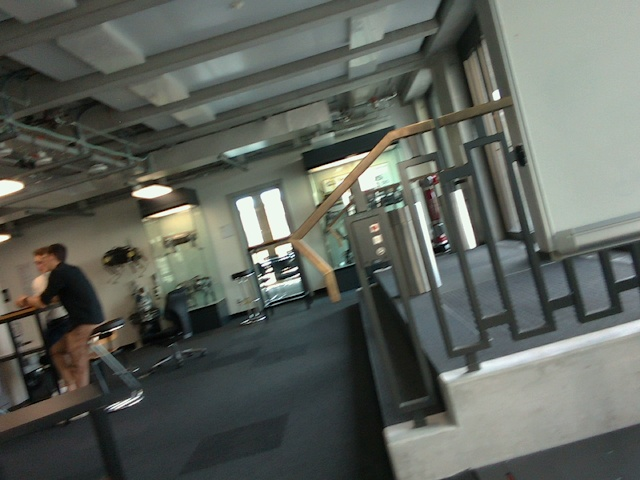

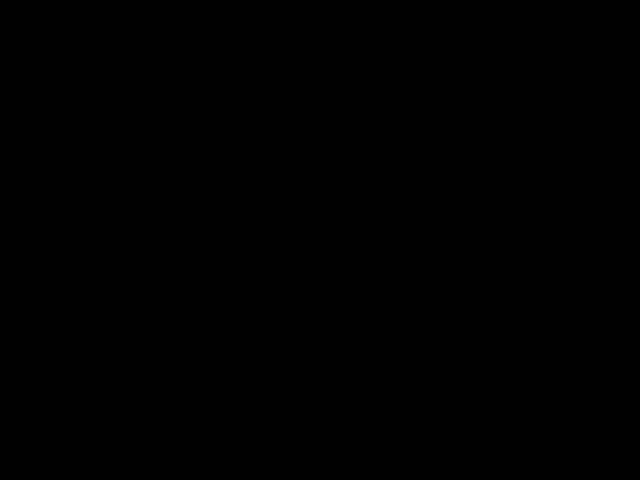

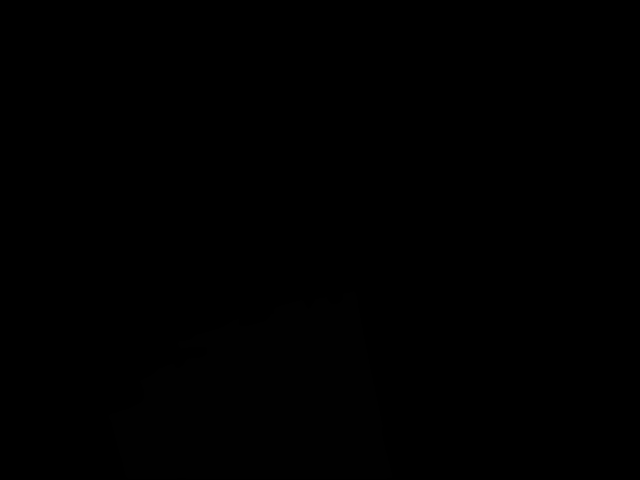

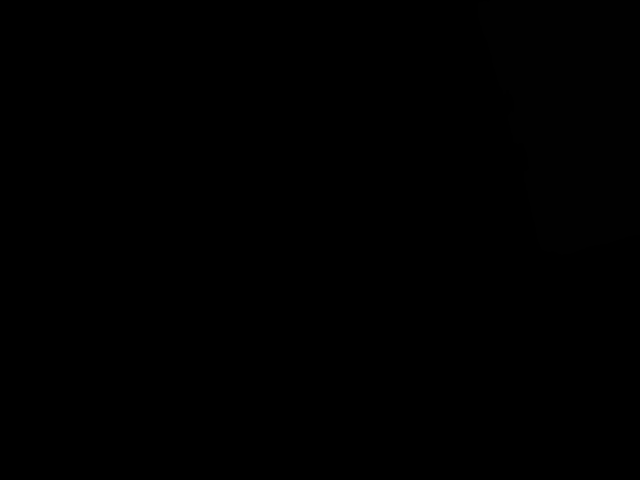

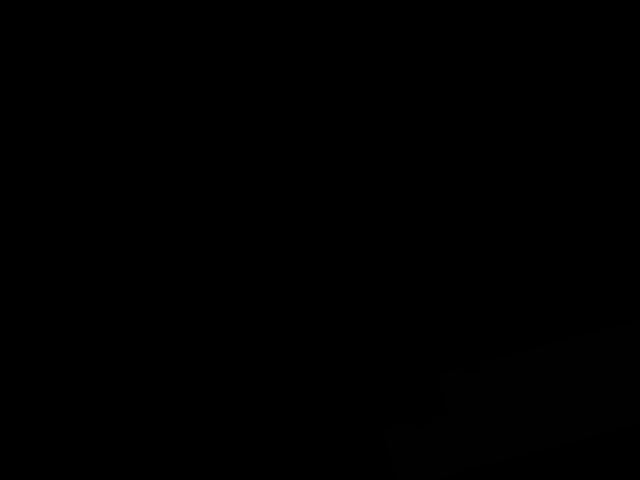

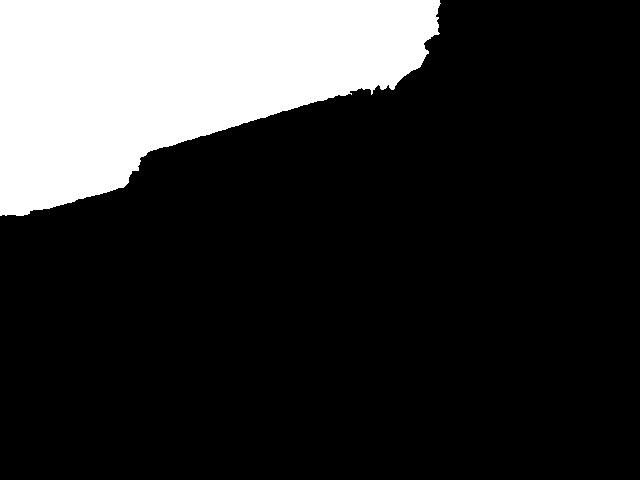


Found 3 hough-lines
Line 0 has points: [(147, 153), (410, 72)]
Line 0 has theta -17.12°
Line 0 has slope -0.31
Line 0 has q 198.27
Line 1 has points: [(21, 215), (126, 185)]
Line 1 has theta -15.95°
Line 1 has slope -0.29
Line 1 has q 221.0
Line 2 has points: [(147, 152), (416, 69)]
Line 2 has theta -17.15°
Line 2 has slope -0.31
Line 2 has q 197.36
Lines 0 and 1 have similar theta -> difference: 1.2
Lines 0 and 1 span a significant area.
Lines 0 and 2 have similar theta -> difference: 0.0
Lines 1 and 2 have similar theta -> difference: 1.2
Lines 1 and 2 span a significant area.
[[-1.  0.  1.]
 [ 0. -1.  0.]
 [ 1.  0. -1.]]

Similarity groups: [[0, 2]]

Starting analysis of sg: [0, 2]
Q avg: 197.8153
M avg: -0.3083
In this Sline, the theta calculated from the bounding box is: -17.1328293264436. This results in a slope of -0.30826748837406537
For this Sline the following points where calculated: [(0, 197), (640, 0)]
Analysis of sg [0, 2] done
In this Sline, the theta calculated from th

NameError: name 'distanceBetweenTwoPoints' is not defined

In [9]:

# LOAD IMAGE ##########################################
# Image description
FRAME_ID = 20
IMG_NAME = "frame" + str(FRAME_ID) + ".jpg"
OUT_IMG_NAME  = "frame"  + str(FRAME_ID)+"_champion_corners.png"
TARGET_DIR = IMAGES_FOLDER + SEL_NAME
IMG_PATH = TARGET_DIR + "/" + IMG_NAME

# Load image to be processed
image_bgr = cv2.imread(IMG_PATH)
cv2_imshow(image_bgr)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
#cv2_imshow(image_rgb)
t1 = time.perf_counter()
# LOADING IMAGE DONE ##################################


# Inference ##########################################
sam_result = mask_generator.generate(image_rgb)
t2 = time.perf_counter()
# Inference done ##########################################


# CHAMPION MASK EXTRACTION #############################################################################################################################

# Get masks and sort them by descending area
sorted_masks = sorted(sam_result, key=lambda x: x['area'], reverse=True)

# Get four largest masks
candidates = []
for i in range(4):
  temp_mask = sorted_masks[i]
  candidates.append(temp_mask['segmentation'])

# Calc areas
areas=[np.sum(m == 255) for m in candidates]

# Prepare containers
champion_mask = None
champion_index = -1

for i in range(len(candidates)):
    img = candidates[i]
    cv2_imshow(img)
    img = np.asarray(img, dtype="uint8")
    num_labels, labels_im = cv2.connectedComponents(img,connectivity=8)

    # I will assume that there is always one mask with only 1 connected component (which equals to num_labels==2)
    if num_labels == 2:
        if champion_index == -1: # There has not been a single-component mask before
            champion_index = i
        else: # There has already been a single-component mask, so we only update the champion if his white area is larger than the predecessor
            if areas[i] > areas[champion_index]:
                champion_index = i

if champion_index != -1:
    champion_mask = candidates[champion_index]*255

cv2_imshow(champion_mask)
t3 = time.perf_counter()
# CHAMPION MASK EXTRACTION #############################################################################################################################

# DETECT CORNERS ######################################################
# Get a corner detection
#try:
champion_mask = np.asarray(champion_mask, dtype="uint8")
detection = cornerDetection.cornerDetection(champion_mask,True)
corner_candidates = detection.get_corner_candidates()
t4 = time.perf_counter()
# DETECTING CORNERS DONE ##############################################

# REJECT OUTLIERS ##########################################################################################
# Get centroid
centroid = detection.calcCentroid()

# Sort candidate corner list regarding distance to centroid
sorted_corner_candidates = sorted(corner_candidates,key=lambda cc : distanceBetweenTwoPoints(cc,centroid))

# Remove all points except the 6 closest to the centroid
corner_champions = sorted_corner_candidates[:6]
t5 = time.perf_counter()
# REJECTING OUTLIERS DONE ################################################################################


# DISPLAY AND SAVE RESULTING IMAGE ##########################################################################################
#print("num of corner champions: "+str(len(corner_champions)))
# Mark corners on image
corner_champion_img = image_bgr.copy()
for cch in corner_champions:
    corner_champion_img = cv2.circle(corner_champion_img, cch, radius=5, color=(255, 255, 0), thickness=-1)
# Save image
OUT_PATH = OUTPUT_FOLDER + OUT_IMG_NAME
cv2_imshow(corner_champion_img)

# DISPLAYING AND SAVING RESULTING IMAGE##########################################################################################



## Process image batch


In [10]:
 # define helper function
def distanceBetweenTwoPoints(p1, p2):
  dis = ((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2) ** 0.5
  return dis

In [12]:
# PREPARE MEASUREMENTS ######
avg_load_dur = 0
avg_inf_dur = 0
avg_mask_extr_dur = 0
avg_cor_det_dur = 0
avg_rej_dur = 0
avg_tot_dur = 0
avg_num_champ_cor = 0
num_fails = 0

test_start_time = time.perf_counter()
# For recoding failes idxs
failed_idxs = []

TARGET_DIR = IMAGES_FOLDER + SEL_NAME
num_frames = len(os.listdir(TARGET_DIR))
# PREPARING MEASUREMENTS DONE
for frame_id in range(1,num_frames+1):
  try:
    # Prep
    t0 = time.perf_counter()
    # LOAD IMAGE ##########################################
    # Image description
    FRAME_ID = frame_id
    IMG_NAME = "frame" + str(FRAME_ID) + ".jpg"
    OUT_IMG_NAME  = "frame"  + str(FRAME_ID)+"_champion_corners.png"
    #IMG_NAME = 'shelf2.png'
    IMG_PATH = TARGET_DIR + "/" + IMG_NAME

    # Load image to be processed
    image_bgr = cv2.imread(IMG_PATH)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    #cv2_imshow(image_rgb)
    t1 = time.perf_counter()
    # LOADING IMAGE DONE ##################################


    # Inference ##########################################
    sam_result = mask_generator.generate(image_rgb)
    t2 = time.perf_counter()
    # Inference done ##########################################


    # CHAMPION MASK EXTRACTION #############################################################################################################################

    # Get masks and sort them by descending area
    sorted_masks = sorted(sam_result, key=lambda x: x['area'], reverse=True)

    # Get four largest masks
    candidates = []
    for i in range(4):
      temp_mask = sorted_masks[i]
      candidates.append(temp_mask['segmentation'])

    # Calc areas
    areas=[np.sum(m == 255) for m in candidates]

    # Prepare containers
    champion_mask = None
    champion_index = -1

    for i in range(len(candidates)):
        img = candidates[i]
        img = np.asarray(img, dtype="uint8")
        num_labels, labels_im = cv2.connectedComponents(img,connectivity=8)

        # I will assume that there is always one mask with only 1 connected component (which equals to num_labels==2)
        if num_labels == 2:
            if champion_index == -1: # There has not been a single-component mask before
                champion_index = i
            else: # There has already been a single-component mask, so we only update the champion if his white area is larger than the predecessor
                if areas[i] > areas[champion_index]:
                    champion_index = i

    if champion_index != -1:
        champion_mask = candidates[champion_index]*255


    t3 = time.perf_counter()
    # CHAMPION MASK EXTRACTION #############################################################################################################################

    # DETECT CORNERS ######################################################
    # Get a corner detection
    #try:
    champion_mask = np.asarray(champion_mask, dtype="uint8")
    detection = cornerDetection.cornerDetection(champion_mask,False)
    corner_candidates = detection.get_corner_candidates()
    t4 = time.perf_counter()
    # DETECTING CORNERS DONE ##############################################

    # REJECT OUTLIERS ##########################################################################################
    # Get centroid
    centroid = detection.calcCentroid()

    # Sort candidate corner list regarding distance to centroid
    sorted_corner_candidates = sorted(corner_candidates,key=lambda cc : distanceBetweenTwoPoints(cc,centroid))

    # Remove all points except the 6 closest to the centroid
    corner_champions = sorted_corner_candidates[:6]
    t5 = time.perf_counter()
    # REJECTING OUTLIERS DONE ################################################################################


    # DISPLAY AND SAVE RESULTING IMAGE ##########################################################################################
    #print("num of corner champions: "+str(len(corner_champions)))
    # Mark corners on image
    corner_champion_img = image_bgr.copy()
    for cch in corner_champions:
        corner_champion_img = cv2.circle(corner_champion_img, cch, radius=5, color=(255, 255, 0), thickness=-1)
    # Save image
    OUT_PATH = OUTPUT_FOLDER + OUT_IMG_NAME
    cv2.imwrite(OUT_PATH, corner_champion_img)

    # DISPLAYING AND SAVING RESULTING IMAGE##########################################################################################

    # UPDATE STATS ###################
    avg_load_dur += (t1-t0)
    avg_inf_dur += (t2-t1)
    avg_mask_extr_dur += (t3-t2)
    avg_cor_det_dur += (t4-t3)
    avg_rej_dur += (t5-t4)
    avg_tot_dur += (t5-t0)
    avg_num_champ_cor += len(corner_champions)
  except:
    num_fails +=1
    failed_idxs.append(frame_id)

# FINAL STAT CALC AND SAVING ################################

test_dur = time.perf_counter()-test_start_time

avg_load_dur /= num_frames
avg_inf_dur /= num_frames
avg_mask_extr_dur /= num_frames
avg_cor_det_dur /= num_frames
avg_rej_dur /= num_frames
avg_tot_dur /= num_frames
avg_num_champ_cor /= num_frames
'''
print('Average loading duration [s]:','%.4f' % avg_load_dur)
print('Average inference duration [s]:','%.4f' % avg_inf_dur)
print('Average mask extraction duration [s]:','%.4f' % avg_mask_extr_dur)
print('Average corner detection duration [s]:','%.4f' % avg_cor_det_dur)
print('Average outlier rejection duration [s]:','%.4f' % avg_rej_dur)
print('Average total dur [s]: ','%.4f' % avg_tot_dur)
print('Average number of found corner champions [s]: ',avg_num_champ_cor)
'''
 # Create json and save json
stats = {}
stats['sel_name'] = SEL_NAME
stats['num_of_imgs_processed'] = num_frames
stats['rej_strat'] = "closest six to centroid"
stats['test_duration'] = test_dur
stats['avg_load_dur'] = avg_load_dur
stats['avg_inf_dur'] = avg_inf_dur
stats['avg_mask_extr_dur'] = avg_mask_extr_dur
stats['avg_cor_det_dur'] = avg_cor_det_dur
stats['avg_rej_dur'] = avg_rej_dur
stats['avg_tot_dur'] = avg_tot_dur
stats['avg_num_champ_cor'] = avg_num_champ_cor
stats['num_fails'] = num_fails
stats['failed_idxs'] = str(failed_idxs)


stats_json_obj = json.dumps(stats)
#stats_json_obj_encoded = stats_json_obj.encode('utf-8')

JSON_FILE_NAME = SEL_NAME + "_stats.json"
JSON_FILE_PATH = OUTPUT_FOLDER + JSON_FILE_NAME
with open(JSON_FILE_PATH, 'w') as f:
  f.write(str(stats_json_obj))

# FINAL STAT CALC AND SAVING DONE ################################



Found 10 hough-lines

Similarity groups: [[1, 4, 9], [2, 6, 8], [3, 5]]

Num of merged straight lines: 5

number of corner candidates: 10

Found 14 hough-lines

Similarity groups: [[0, 7, 8, 11, 12], [1, 9], [2, 4, 10], [3, 5, 13]]

Num of merged straight lines: 5

number of corner candidates: 10

Found 11 hough-lines

Similarity groups: [[0, 1], [3, 5, 8], [4, 6, 9]]

Num of merged straight lines: 6

number of corner candidates: 17

Found 14 hough-lines

Similarity groups: [[1, 5, 8, 13], [2, 9], [4, 7, 10, 12], [6, 11]]

Num of merged straight lines: 6

number of corner candidates: 15

Found 13 hough-lines

Similarity groups: [[0, 8, 10], [1, 9], [3, 4, 11], [7, 12]]

Num of merged straight lines: 7

number of corner candidates: 22

Found 16 hough-lines

Similarity groups: [[0, 13], [1, 4, 14], [2, 6, 10], [3, 9, 15], [5, 12], [7, 11]]

Num of merged straight lines: 7

number of corner candidates: 22

Found 14 hough-lines

Similarity groups: [[0, 12], [1, 9, 10], [2, 3], [4, 5, 11, 

### Read json to make sure it is readable

In [ ]:
# Load json file
JSON_FILE_NAME = SEL_NAME + "_stats.json"
JSON_FILE_PATH = OUTPUT_FOLDER + JSON_FILE_NAME

with open(JSON_FILE_PATH) as json_data:
  stats = json.load(json_data)


# Reconstruct data
recon_SEL_NAME = stats['sel_name']
recon_num_frames = stats['num_of_imgs_processed']
recon_rej_strat = stats['rej_strat']
recon_test_dur = stats['test_duration']
recon_avg_load_dur = stats['avg_load_dur']
recon_avg_inf_dur = stats['avg_inf_dur']
recon_avg_mask_extr_dur = stats['avg_mask_extr_dur']
recon_avg_cor_det_dur = stats['avg_cor_det_dur']
recon_avg_rej_dur = stats['avg_rej_dur']
recon_avg_tot_dur = stats['avg_tot_dur']
recon_avg_num_champ_cor = stats['avg_num_champ_cor']
recon_num_fails = stats['num_fails']
recon_failed_idxs = stats['failed_idxs']

# Print stats data
print("Sel name: "+ recon_SEL_NAME)
print("Num of frames processed: "+ str(recon_num_frames))
print("Outlier rejection strategy: "+ recon_rej_strat)
print("Duration of test: " + '%.4f' % recon_test_dur)
print('Average loading duration [s]:','%.4f' % recon_avg_load_dur)
print('Average inference duration [s]:','%.4f' % recon_avg_inf_dur)
print('Average mask extraction duration [s]:','%.4f' % recon_avg_mask_extr_dur)
print('Average corner detection duration [s]:','%.4f' % recon_avg_cor_det_dur)
print('Average outlier rejection duration [s]:','%.4f' % recon_avg_rej_dur)
print('Average total dur [s]: ','%.4f' % recon_avg_tot_dur)
print('Average number of found corner champions [s]: ',recon_avg_num_champ_cor)
print("Number of fails: "+str(recon_num_fails))
print("Indizes of failed images: "+recon_failed_idxs)



## Results visualisation with Supervision


In [ ]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

cv2_imshow(annotated_image)

'''
sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)
'''